# Imports


In [225]:
import os
import glob
from cv2 import cv2
import numpy as np 
import pandas as pd 
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt


from keras.layers import Input
from xml.etree import ElementTree
import xml.etree.ElementTree as ET
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout





# Directories 

In [226]:
input_data_path = './dataset/images'
annotations_path = "./dataset/annotations"
images = [*os.listdir("./dataset/images")]
output_data_path =  '.'

In [227]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   

def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params     

    
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res        

In [228]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [229]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73


In [230]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [231]:
df["name"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

# Visualization


Text(0, 0.5, 'name')

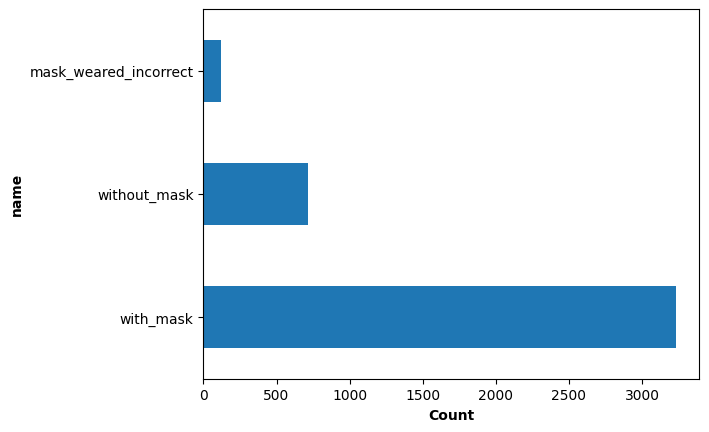

In [232]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

# Split the data directories to train, test, and validation folders

In [233]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [234]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [235]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [236]:
cropped_faces = [extract_faces(img, df) for img in images]
flat_cropped_faces = sum(cropped_faces, [])

In [237]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [238]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


# Data Splitting

In [239]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [240]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [241]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')        

# CNN Model 
Sequential model is selected (any other pretrained model can be used )

In [242]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 17, 17, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 64)         

In [243]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='./train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='./val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='./test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [244]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [245]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [246]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [247]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50


C:\Users\Hoda Azzam\AppData\Local\Temp\ipykernel_20296\2632000927.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


50/50 [==============================] - 4s 43ms/step - loss: 0.6238 - accuracy: 0.7850 - recall: 0.7475 - precision: 0.8081 - auc: 0.8988 - val_loss: 0.3901 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8806 - val_auc: 0.9682 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 2s 33ms/step - loss: 0.4172 - accuracy: 0.8500 - recall: 0.8150 - precision: 0.8740 - auc: 0.9523 - val_loss: 0.3212 - val_accuracy: 0.9167 - val_recall: 0.9167 - val_precision: 0.9167 - val_auc: 0.9690 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 2s 31ms/step - loss: 0.3318 - accuracy: 0.8800 - recall: 0.8675 - precision: 0.8852 - auc: 0.9692 - val_loss: 0.2674 - val_accuracy: 0.9167 - val_recall: 0.9167 - val_precision: 0.9167 - val_auc: 0.9787 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 29ms/step - loss: 0.3009 - accuracy: 0.9150 - recall: 0.9075 - precision: 0.9190 - auc: 0.9726 - val_loss: 0.2557 - val_accuracy: 0.9167 - val_recall: 0

In [248]:
predictions = model.predict(test_generator)
predictions

31/31 [==============================] - 1s 19ms/step


array([[1.05688229e-01, 8.94012034e-01, 2.99698062e-04],
       [2.73392070e-02, 9.64413226e-01, 8.24760832e-03],
       [6.98372200e-02, 9.03893113e-01, 2.62697283e-02],
       [6.07664622e-02, 9.37715411e-01, 1.51809014e-03],
       [9.21661183e-02, 9.07489419e-01, 3.44406813e-04],
       [3.14819038e-01, 6.83469474e-01, 1.71144924e-03],
       [2.55510453e-02, 9.58995938e-01, 1.54530518e-02],
       [1.16061994e-04, 9.99883652e-01, 1.95221673e-07],
       [4.66882531e-03, 9.95148718e-01, 1.82442964e-04],
       [1.03444944e-03, 9.98865008e-01, 1.00638805e-04],
       [6.73890463e-04, 9.99298334e-01, 2.78004209e-05],
       [3.13877536e-04, 9.99683976e-01, 2.12706072e-06],
       [5.93934616e-04, 9.99394178e-01, 1.18843109e-05],
       [1.15006114e-03, 9.98841345e-01, 8.56313090e-06],
       [9.35272966e-03, 9.82594848e-01, 8.05236027e-03],
       [7.70038678e-05, 9.99922752e-01, 1.78965180e-07],
       [4.11701314e-02, 8.50204229e-01, 1.08625695e-01],
       [2.08578259e-03, 9.97706

# Loss Function and Acuuracy Visualization 

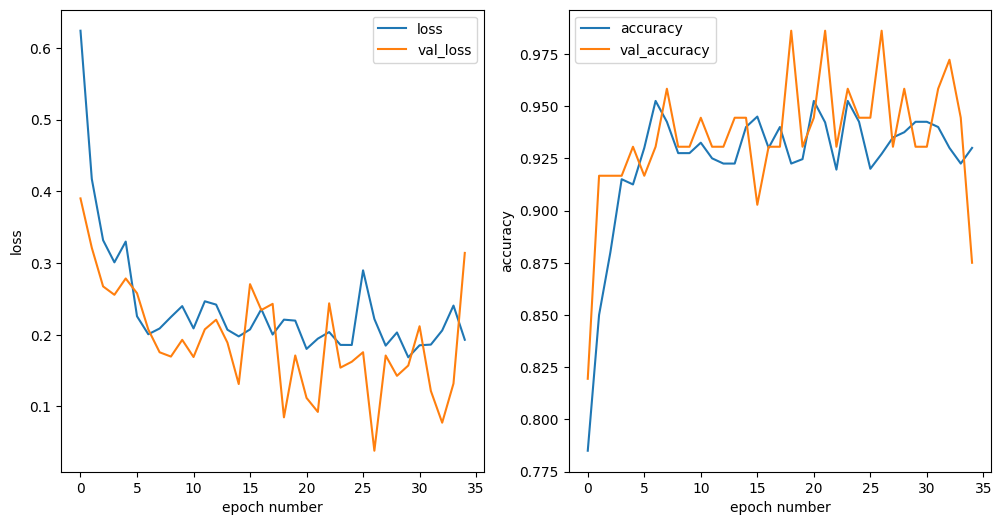

In [249]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

plot_loss_and_accuracy(model_history.history)

# Pick an image and predict

31/31 [==============================] - 0s 8ms/step
with_mask || with_mask\maksssksksss148_(151, 89).png


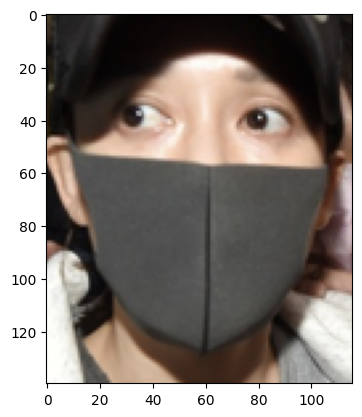

In [250]:
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

# Model Evaluation

31/31 [==============================] - 0s 8ms/step


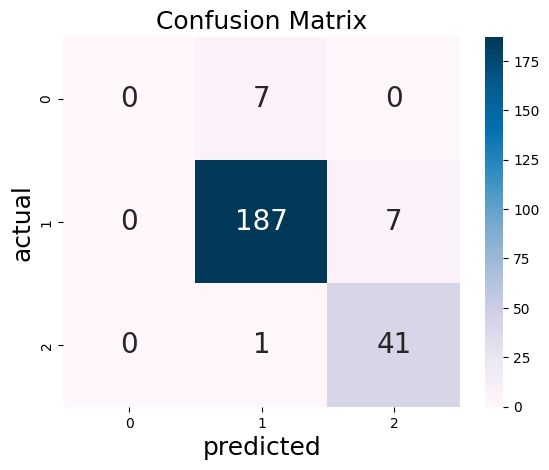

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  0, 195,  48], dtype=int64)

In [251]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)
display(classes)
np.bincount(y_pred)